<a href="https://colab.research.google.com/github/sutatoruta/sandbox/blob/main/srukf_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

In [12]:

#実際はSのまま更新する
def cholupdate(S,u,mu):
  ret = S @ S.T
  for c in range(u.shape[1]):
    a = u[:,c]
    ret += np.sign(mu) * np.sqrt(np.abs(mu)) *  a @ a.T
  return np.linalg.cholesky(ret)
def propagate_sigma(sigma,input,func):
  result = []
  for c in range(sigma.shape[1]):
    result.append(func(sigma[:,c], input).T.tolist()[0])
  return np.matrix(result).T

class srUKF:
  def __init__(self,initial_state,initial_P,R,Q,predict_func,output_func) -> None:
    self.state = initial_state
    self.S =  np.linalg.cholesky(initial_P)
    self.predict_func = predict_func
    self.output_func =output_func
    U, s, V = np.linalg.svd(R)
    self.cholesky_R = U @ np.diag(np.sqrt(s))
    U, s, V = np.linalg.svd(Q)
    self.cholesky_Q = U @ np.diag(np.sqrt(s))

    self.alpha = 1
    self.beta = 2

  @property
  def L(self):
      return self.state.size

  @property
  def kappa(self):
      return 3 - self.L

  @property
  def lamda(self):
      return (self.alpha ** 2) * (self.L + self.kappa) - self.L

  @property
  def weight(self):
    w = np.empty(2*self.L+1)
    w[0] = self.lamda / (self.L + self.lamda)
    w[1:] = 1 / (2 * (self.L + self.lamda) )
    return w

  @property
  def weight_c(self):
    w = self.weight
    w[0] +=  1 - self.alpha ** 2 + self.beta
    return w

  @property
  def sigma(self):
    distance = np.sqrt(self.L + self.lamda) * self.S
    return np.hstack((self.state, self.state + distance, self.state - distance))

  def predict(self,input):
    x_sigma = propagate_sigma(self.sigma, input,self.predict_func)
    self.state = np.multiply(self.weight, x_sigma).sum(axis=1)
    x_diff = x_sigma - self.state
    self.S = np.linalg.qr(np.hstack((np.multiply(np.sqrt(self.weight_c[1:]), x_diff[:,1:]), self.cholesky_R)).T, 'r').T
    self.S = cholupdate(self.S, x_diff[:,0], self.weight_c[0])
    return self.state,self.S

  def correct(self,observation,input):
    x_sigma = self.sigma
    y_sigma = propagate_sigma(x_sigma, input,self.output_func)
    output = np.multiply(self.weight, y_sigma).sum(axis=1)

    x_diff = x_sigma - self.state
    y_diff = y_sigma - output

    S_y = np.linalg.qr(np.hstack((np.multiply(np.sqrt(self.weight_c[1:]), y_diff[:,1:]), self.cholesky_Q)).T, 'r').T
    S_y = cholupdate(S_y, y_diff[:,0], self.weight_c[0])

    P_xy = np.zeros((self.L, observation.size))
    for i in range(2 * self.L + 1):
      P_xy += self.weight_c[i] * (x_diff[:,i] @ y_diff[:,i].T)
    #実際は後退代入
    K = P_xy @ np.linalg.inv(S_y.T) @ np.linalg.inv(S_y)
    self.state += K  @ (observation - output)
    self.S = cholupdate(self.S, K @ S_y, -1)
    return self.state,self.S


[[ 0.70271196  0.77281032  0.69536368 ... -0.57577199 -0.44715118
  -0.77389096]
 [ 0.76204193  0.83135098  0.73694726 ... -0.98887794 -1.10134255
  -1.15931106]]


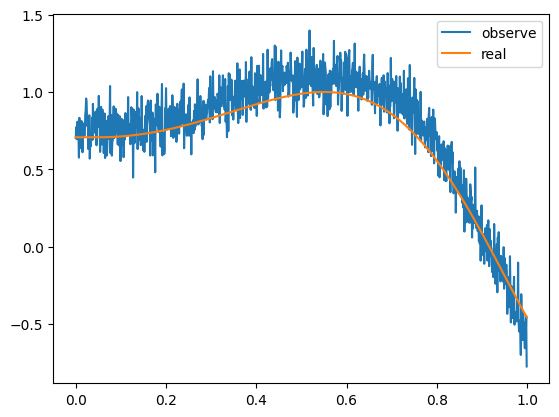

In [13]:
#サンプリング周期(s)
dt = 0.001
#時刻
t = np.arange(0,1,dt)
#変化を始める時刻(s)
t_0 = 0.05
omega = np.pi * (t-t_0)
#初期位相(rad)
phi = np.pi / 4
#位相の真値
phase = omega * (t-t_0) + phi
phase[0:int(t_0/dt)] = phi

#振幅
amp = 1 + 0.5 * np.sin(phase / 7)

#真値
real = np.vstack((np.multiply(amp, np.sin(phase)), np.multiply(amp, np.sin(phase + np.pi/2))))
#ノイズ
noise = np.vstack((np.random.normal(loc=0,scale=0.1,size=len(t)),np.random.normal(loc=0,scale=0.1,size=len(t))))
#観測値
observe  = real + noise
print(observe)
plt.plot(t,observe[0,:],label="observe")
plt.plot(t,np.sin(phase),label="real")
plt.legend()

(matrix([[3.59029767],
         [5.43417871]]),
 matrix([[0.00018   , 0.00251417],
         [0.00251417, 0.07109171]]))

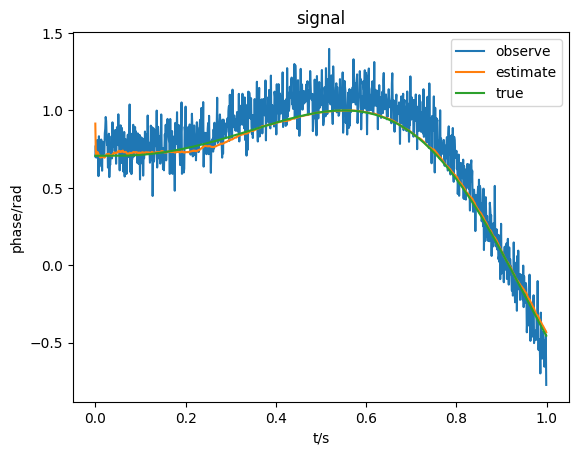

In [14]:
#状態変数 角度、角速度
state = np.matrix([0,0]).T
P = np.matrix([
    [1,0],
    [0,1]
    ])
G = np.matrix([[dt ** 2 / 2],[dt]])
R = 1 / dt * G @ G.T
Q = 0.01 * np.identity(2)

def predict_func(state,input):
    return np.vstack((state[0] + state[1] * dt, state[1]))
def output_func(state,input):
    amp = 1 + 0.5 * np.sin(state[0] / 7)
    return np.vstack((np.multiply(amp, np.sin(state[0])), np.multiply(amp, np.sin(state[0] + np.pi / 2))))

ukf = srUKF(state,P,R,Q,predict_func,output_func)

#推定位相の配列
phase_est = []
phase_upper = []
phase_lower = []
for data in observe.T:
  state,S = ukf.predict([])
  state,S = ukf.correct(np.matrix(data).T,[])
  phase_est.append(state[0,0])
  P = S @ S.T
  phase_sigma = np.sqrt(P[0,0])
  phase_upper.append(state[0,0] + 3 * phase_sigma)
  phase_lower.append(state[0,0] - 3 * phase_sigma)
plt.plot(t,observe[0,:],label="observe")
plt.plot(t,np.sin(phase_est),label="estimate")
plt.plot(t,np.sin(phase),label="true")
plt.title("signal")
plt.xlabel("t/s")
plt.ylabel("phase/rad")
plt.legend()
state,S @ S.T

Text(0, 0.5, '(true-estimate)/rad')

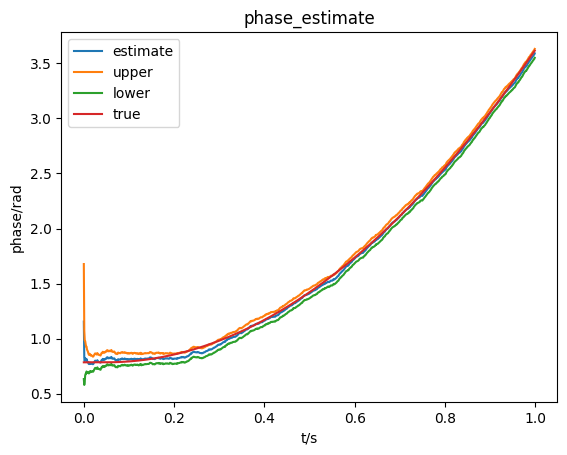

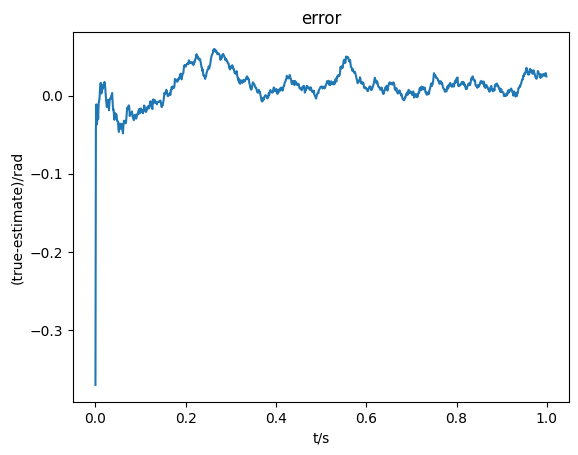

In [15]:
plt.plot(t,phase_est,label="estimate")
plt.plot(t,phase_upper,label="upper")
plt.plot(t,phase_lower,label="lower")
plt.plot(t,phase,label="true")
plt.title("phase_estimate")
plt.xlabel("t/s")
plt.ylabel("phase/rad")
plt.legend()

plt.figure()
plt.plot(t,phase-phase_est)
plt.title("error")
plt.xlabel("t/s")
plt.ylabel("(true-estimate)/rad")